In [0]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import argparse, os, gzip, torch, time, pickle
import torch.nn as nn
import torch.optim as optim
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [0]:
def dataloader(dataset, input_size, batch_size, split = 'train'):
  
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize([0.5], [0.5])
  ])
  
  if dataset == 'mnist':
    data_loader = DataLoader(
        datasets.MNIST('data/mnist', train = True, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'fashion-mnist':
    data_loader = DataLoader(
        datasets.FashionMNIST('data/fashion-mnist', train = True, download = True,
                              transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'cifar10':
    data_loader = DataLoader(
        datasets.CIFAR10('data/cifar10', train = True, download = True,
                         transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'svhn':
    data_loader = DataLoader(
        datasets.SVHN('data/svhn', split = split, download = True,
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'stl10':
    data_loader = DataLoader(
        datasets.STL10('data/stl10', split = split, download = True,
                       transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  elif dataset == 'lsun-bed':
    data_loader = DataLoader(
        datasets.LSUN('data/lsun', classes = ['bedroom-train'],
                      transform = transform),
        batch_size = batch_size,
        shuffle = True
    )
    
  return data_loader

In [0]:
def load_mnist(dataset):
  data_dir = os.path.join("./data", dataset)
  
  def extract_data(filename, num_data, head_size, data_size):
    with gzip.open(filename) as bytestream:
      bytestream.read(head_size)
      buf = bytestream.read(data_size * num_data)
      data = np.frombuffer(buf, dtype = np.uint8).astype(np.float)
    return data
  
  data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
  trX = data.reshape((60000, 28, 28, 1))
  
  data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
  trY = data.reshape((60000))
  
  data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
  teX = data.reshape((10000, 28, 28, 1))
  
  data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
  teY = data.reshape((10000))
  
  trY = np.asarray(trY).astype(np.int)
  teY = np.asarray(teY)
  
  X = np.concatenate((trX, teX), axis = 0)
  y = np.concatenate((trY, teY), axis = 0).astype(np.int)
  
  seed = 1998
  np.random.seed(seed)
  np.random.shuffle(X)
  np.random.seed(seed)
  np.random.shuffle(y)
  
  y_vec = np.zeros((len(y), 10), dtype = np.float)
  for i, label in enumerate(y):
    y_vec[i, y[i]] = 1
  
  
  X = X.transpose(0, 3, 1, 2) / 255.
  
  X = torch.from_numpy(X).type(torch.FloatTensor)
  y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
  return X, y_vec

In [0]:
def print_network(net):
  num_params = 0
  for param in net.parameters():
    num_params += param.numel()
  print(net)
  print('Total number of parameters: %d' % num_params)

In [0]:
def save_images(images, size, image_path):
  return imsave(images, size, image_path)

def imsave(images, size, path):
  image = np.squeeze(merge(images, size))
  return imageio.imwrite(path, image)

In [0]:
def merge(images, size):
  h, w = images.shape[1], images.shape[2]
  
  if(images.shape[3] in (3, 4)):
    c = images.shape[3]
    img = np.zeros((h * size[0], w * size[1], c))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w, :] = image
    return img
  
  elif images.shape[3] == 1:
    img = np.zeros((h * size[0], w * size[1]))
    for idx, image in enumerate(images):
      i = idx % size[1]
      j = idx // size[1]
      img[j * h: j * h + h, i * w: i * w + w] = image[:, :, 0]
    return img
  
  else:
    raise ValueError('in merge(images, size) images parameter must have dimensions: HxW or HxWx3 or HxWx4')

In [0]:
def generate_animation(path, num):
  images = []
  for e in range(num):
    img_name = path + '_epoch%03d' % (e + 1) + '.png'
    images.append(imageio.imread(img_name))
  imageio.mimsave(path + '_generate_animation.gif', images, fps = 5)

In [0]:
def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
  
  x = range(len(hist['D_loss']))
  
  y1 = hist['D_loss']
  y2 = hist['G_loss']
  
  plt.plot(x, y1, label = 'D_loss')
  plt.plot(x, y2, label = 'G_loss')
  
  plt.xlabel('Iter')
  plt.ylabel('Loss')
  
  plt.legend(loc = 4)
  plt.grid(True)
  plt.tight_layout()
  
  path = os.path.join(path, model_name + '_loss.png')
  
  plt.savefig(path)
  
  plt.close()

In [0]:
def initialize_weights(net):
  
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()
    elif isinstance(m, nn.Linear):
      m.weight.data.normal_(0, 0.02)
      m.bias.data.zero_()

In [0]:
class generator(nn.Module):
  
  ## Network Architecture is exactly the same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
  
  def __init__(self, input_dim = 100, output_dim = 1, input_size = 32):
    super(generator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.fc = nn.Sequential(
        nn.Linear(self.input_dim, 1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
        nn.ReLU(),
    )
    
    self.deconv = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
        nn.Tanh(),
    )
    
    initialize_weights(self)
    
    
  def forward(self, input):
    x = self.fc(input)
    x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
    x = self.deconv(x)
    return x

In [0]:
class discriminator(nn.Module):
  
  ## Network Architecture is exactly the same as in infoGAN (https://arxiv.org/abs/1606.03657)
  ## Architecture: (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
  
  def __init__(self, input_dim = 1, output_dim = 1, input_size = 32):
    super(discriminator, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.input_size = input_size
    
    self.conv = nn.Sequential(
        nn.Conv2d(self.input_dim, 64, 4, 2, 1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 128, 4, 2, 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
    )
    
    self.fc = nn.Sequential(
        nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(0.2),
        nn.Linear(1024, self.output_dim),
        nn.Sigmoid(),
    )
    
    initialize_weights(self)
    
  
  def forward(self, input):
    x = self.conv(input)
    x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
    x = self.fc(x)
    
    return x

In [0]:
class LSGAN(object):
  
  def __init__(self):
    ## parameters
    self.epoch = 50
    self.sample_num = 100
    self.batch_size = 64
    self.save_dir = 'models'
    self.result_dir = 'results'
    self.dataset = 'fashion-mnist'
    self.log_dir = 'logs'
    self.gpu_mode = True
    self.model_name = 'LSGAN'
    self.input_size = 28
    self.z_dim = 62
    
    
    ## load dataset
    self.data_loader = dataloader(self.dataset,
                                  self.input_size,
                                  self.batch_size)
    data = self.data_loader.__iter__().__next__()[0]
    
    
    ## networks init
    self.G = generator(input_dim = self.z_dim,
                       output_dim = data.shape[1],
                       input_size = self.input_size)
    self.D = discriminator(input_dim = data.shape[1],
                           output_dim = 1,
                           input_size = self.input_size)
    self.G_optimizer = optim.Adam(self.G.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    self.D_optimizer = optim.Adam(self.D.parameters(),
                                  lr = 0.0002,
                                  betas = (0.5, 0.999))
    
    
    if self.gpu_mode:
      self.G.cuda()
      self.D.cuda()
      self.MSE_loss = nn.MSELoss().cuda()
    else:
      self.MSE_loss = nn.MSELoss()
      
    
    print('-----------Networks Architecture------------')
    print_network(self.G)
    print_network(self.D)
    print('--------------------------------------------')
    
    
    ## fixed noise
    self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
    if self.gpu_mode:
      self.sample_z_ = self.sample_z_.cuda()
      
  
  def train(self):
    self.train_hist = {}
    self.train_hist['D_loss'] = []
    self.train_hist['G_loss'] = []
    self.train_hist['per_epoch_time'] = []
    self.train_hist['total_time'] = []
    
    self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
    if self.gpu_mode:
      self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()
      
    
    self.D.train()
    print('training start !')
    start_time = time.time()
    for epoch in range(self.epoch):
      self.G.train()
      epoch_start_time = time.time()
      for iter, (x_, _) in enumerate(self.data_loader):
        if iter == self.data_loader.dataset.__len__() // self.batch_size:
          break
          
        z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
          x_, z_ = x_.cuda(), z_.cuda()
          
          
        ## update D network
        self.D_optimizer.zero_grad()
        
        D_real = self.D(x_)
        D_real_loss = self.MSE_loss(D_real, self.y_real_)
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        D_fake_loss = self.MSE_loss(D_fake, self.y_fake_)
        
        D_loss = D_real_loss + D_fake_loss
        self.train_hist['D_loss'].append(D_loss.item())
        
        D_loss.backward()
        self.D_optimizer.step()
        
        
        ## update G network
        self.G_optimizer.zero_grad()
        
        G_ = self.G(z_)
        D_fake = self.D(G_)
        G_loss = self.MSE_loss(D_fake, self.y_real_)
        self.train_hist['G_loss'].append(G_loss.item())
        
        G_loss.backward()
        self.G_optimizer.step()
        
        
        if ((iter + 1) % 100) == 0:
          print("Epoch: [%2d] [%4d / %4d] D_loss: %.8f, G_loss: %.8f" %
                ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size,
                 D_loss.item(), G_loss.item()))
          
      self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
      with torch.no_grad():
        self.visualize_results((epoch + 1))
        
    self.train_hist['total_time'].append(time.time() - start_time)
    print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
                                                                    self.epoch, 
                                                                    self.train_hist['total_time'][0]))
    print("Training finish! Saved training results")
    
    self.save()
    
    
    generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name, 
                       self.epoch)
    
    loss_plot(self.train_hist, 
              os.path.join(self.save_dir, self.dataset, self.model_name),
              self.model_name)
    
  
  def visualize_results(self, epoch, fix = True):
    self.G.eval()
    
    if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
      os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)
    
    tot_num_samples = min(self.sample_num, self.batch_size)
    image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))
    
    if fix:
      """ fixed noise """
      samples = self.G(self.sample_z_)
      
    else:
      """ random noise """
      sample_z_ = torch.rand((self.batch_size, self.z_dim))
      if self.gpu_mode:
        sample_z_ = sample_z_.cuda()
        
      samples = self.G(sample_z_)
      
    
    if self.gpu_mode:
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
    else:
      samples = samples.data.numpy().transpose(0, 2, 3, 1)
      
    
    samples = (samples + 1) / 2
    save_images(samples[:image_frame_dim * image_frame_dim, :, :, :],
                [image_frame_dim, image_frame_dim],
                self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')
    
  
  def save(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    if not os.path.exists(save_dir):
      os.makedirs(save_dir)
      
    torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
    torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))
    
    with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
      pickle.dump(self.train_hist, f)
      
      
  def load(self):
    save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)
    
    self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
    self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [13]:
def main():
  
  lsgan = LSGAN()
  
  lsgan.train()
  print(" [**] Training finished!")
  
  ## visualize learned generator
  lsgan.visualize_results(50)
  print(" [**] Testing finished!")
  

if __name__ == '__main__':
  main()

  0%|          | 0/26421880 [00:00<?, ?it/s]

26427392it [00:00, 69206712.59it/s]                              


Extracting data/fashion-mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 390661.33it/s]
0it [00:00, ?it/s]

Extracting data/fashion-mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz


4423680it [00:00, 25680883.72it/s]                         
8192it [00:00, 185821.73it/s]


Extracting data/fashion-mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/fashion-mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
-----------Networks Architecture------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6640193
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64,

Epoch: [ 2] [ 100 /  937] D_loss: 0.36815494, G_loss: 0.36408556
Epoch: [ 2] [ 200 /  937] D_loss: 0.34050959, G_loss: 0.37662280
Epoch: [ 2] [ 300 /  937] D_loss: 0.31692606, G_loss: 0.39221793
Epoch: [ 2] [ 400 /  937] D_loss: 0.34153014, G_loss: 0.44670004
Epoch: [ 2] [ 500 /  937] D_loss: 0.38886398, G_loss: 0.39594525
Epoch: [ 2] [ 600 /  937] D_loss: 0.37645400, G_loss: 0.43511274
Epoch: [ 2] [ 700 /  937] D_loss: 0.33764401, G_loss: 0.44681501
Epoch: [ 2] [ 800 /  937] D_loss: 0.42090037, G_loss: 0.37040049
Epoch: [ 2] [ 900 /  937] D_loss: 0.36881191, G_loss: 0.43578780


Epoch: [ 3] [ 100 /  937] D_loss: 0.33733678, G_loss: 0.45115206
Epoch: [ 3] [ 200 /  937] D_loss: 0.35179189, G_loss: 0.40430561
Epoch: [ 3] [ 300 /  937] D_loss: 0.28092459, G_loss: 0.44491935
Epoch: [ 3] [ 400 /  937] D_loss: 0.34346297, G_loss: 0.43112928
Epoch: [ 3] [ 500 /  937] D_loss: 0.37592757, G_loss: 0.42474666
Epoch: [ 3] [ 600 /  937] D_loss: 0.32183066, G_loss: 0.46074915
Epoch: [ 3] [ 700 /  937] D_loss: 0.33221436, G_loss: 0.41411820
Epoch: [ 3] [ 800 /  937] D_loss: 0.33994237, G_loss: 0.45003578
Epoch: [ 3] [ 900 /  937] D_loss: 0.32339740, G_loss: 0.45412028


Epoch: [ 4] [ 100 /  937] D_loss: 0.31915861, G_loss: 0.42128924
Epoch: [ 4] [ 200 /  937] D_loss: 0.33448768, G_loss: 0.47571796
Epoch: [ 4] [ 300 /  937] D_loss: 0.28659993, G_loss: 0.45040962
Epoch: [ 4] [ 400 /  937] D_loss: 0.36221230, G_loss: 0.44491208
Epoch: [ 4] [ 500 /  937] D_loss: 0.33298713, G_loss: 0.44501096
Epoch: [ 4] [ 600 /  937] D_loss: 0.31229544, G_loss: 0.46298653
Epoch: [ 4] [ 700 /  937] D_loss: 0.39952198, G_loss: 0.48026150
Epoch: [ 4] [ 800 /  937] D_loss: 0.28633168, G_loss: 0.48197740
Epoch: [ 4] [ 900 /  937] D_loss: 0.33607376, G_loss: 0.47980571


Epoch: [ 5] [ 100 /  937] D_loss: 0.29845130, G_loss: 0.45637679
Epoch: [ 5] [ 200 /  937] D_loss: 0.37017328, G_loss: 0.42463386
Epoch: [ 5] [ 300 /  937] D_loss: 0.32008964, G_loss: 0.45367268
Epoch: [ 5] [ 400 /  937] D_loss: 0.33809847, G_loss: 0.44767261
Epoch: [ 5] [ 500 /  937] D_loss: 0.33078033, G_loss: 0.47844425
Epoch: [ 5] [ 600 /  937] D_loss: 0.35583070, G_loss: 0.43047228
Epoch: [ 5] [ 700 /  937] D_loss: 0.31582335, G_loss: 0.44390568
Epoch: [ 5] [ 800 /  937] D_loss: 0.33779752, G_loss: 0.44739649
Epoch: [ 5] [ 900 /  937] D_loss: 0.33672220, G_loss: 0.45332664


Epoch: [ 6] [ 100 /  937] D_loss: 0.31523484, G_loss: 0.51899451
Epoch: [ 6] [ 200 /  937] D_loss: 0.30350095, G_loss: 0.48168749
Epoch: [ 6] [ 300 /  937] D_loss: 0.29848045, G_loss: 0.55004680
Epoch: [ 6] [ 400 /  937] D_loss: 0.34545574, G_loss: 0.45017627
Epoch: [ 6] [ 500 /  937] D_loss: 0.38711852, G_loss: 0.50197476
Epoch: [ 6] [ 600 /  937] D_loss: 0.32940036, G_loss: 0.48525539
Epoch: [ 6] [ 700 /  937] D_loss: 0.30988771, G_loss: 0.48223937
Epoch: [ 6] [ 800 /  937] D_loss: 0.27143285, G_loss: 0.53583419
Epoch: [ 6] [ 900 /  937] D_loss: 0.28923696, G_loss: 0.46104178


Epoch: [ 7] [ 100 /  937] D_loss: 0.30250007, G_loss: 0.48374224
Epoch: [ 7] [ 200 /  937] D_loss: 0.30429447, G_loss: 0.51752192
Epoch: [ 7] [ 300 /  937] D_loss: 0.31907490, G_loss: 0.47949317
Epoch: [ 7] [ 400 /  937] D_loss: 0.39020759, G_loss: 0.43750811
Epoch: [ 7] [ 500 /  937] D_loss: 0.29027066, G_loss: 0.52793646
Epoch: [ 7] [ 600 /  937] D_loss: 0.31946707, G_loss: 0.45305890
Epoch: [ 7] [ 700 /  937] D_loss: 0.36947477, G_loss: 0.47602504
Epoch: [ 7] [ 800 /  937] D_loss: 0.33687645, G_loss: 0.46258223
Epoch: [ 7] [ 900 /  937] D_loss: 0.32928503, G_loss: 0.46198547


Epoch: [ 8] [ 100 /  937] D_loss: 0.26525152, G_loss: 0.49179095
Epoch: [ 8] [ 200 /  937] D_loss: 0.35322621, G_loss: 0.40879932
Epoch: [ 8] [ 300 /  937] D_loss: 0.30598220, G_loss: 0.48959503
Epoch: [ 8] [ 400 /  937] D_loss: 0.29382187, G_loss: 0.52455056
Epoch: [ 8] [ 500 /  937] D_loss: 0.32080758, G_loss: 0.43620038
Epoch: [ 8] [ 600 /  937] D_loss: 0.36047485, G_loss: 0.45231545
Epoch: [ 8] [ 700 /  937] D_loss: 0.30853820, G_loss: 0.51152647
Epoch: [ 8] [ 800 /  937] D_loss: 0.30503395, G_loss: 0.48843408
Epoch: [ 8] [ 900 /  937] D_loss: 0.28673041, G_loss: 0.48937777


Epoch: [ 9] [ 100 /  937] D_loss: 0.30076855, G_loss: 0.53759098
Epoch: [ 9] [ 200 /  937] D_loss: 0.28460538, G_loss: 0.51366413
Epoch: [ 9] [ 300 /  937] D_loss: 0.30458656, G_loss: 0.55041337
Epoch: [ 9] [ 400 /  937] D_loss: 0.38441890, G_loss: 0.43609142
Epoch: [ 9] [ 500 /  937] D_loss: 0.30177641, G_loss: 0.48985377
Epoch: [ 9] [ 600 /  937] D_loss: 0.33029589, G_loss: 0.48827106
Epoch: [ 9] [ 700 /  937] D_loss: 0.30851424, G_loss: 0.51744831
Epoch: [ 9] [ 800 /  937] D_loss: 0.25939137, G_loss: 0.55532098
Epoch: [ 9] [ 900 /  937] D_loss: 0.34492788, G_loss: 0.45781648


Epoch: [10] [ 100 /  937] D_loss: 0.27938849, G_loss: 0.51083726
Epoch: [10] [ 200 /  937] D_loss: 0.23782024, G_loss: 0.53266233
Epoch: [10] [ 300 /  937] D_loss: 0.30180395, G_loss: 0.58053809
Epoch: [10] [ 400 /  937] D_loss: 0.30051690, G_loss: 0.55098164
Epoch: [10] [ 500 /  937] D_loss: 0.29614744, G_loss: 0.49930805
Epoch: [10] [ 600 /  937] D_loss: 0.29025704, G_loss: 0.53850806
Epoch: [10] [ 700 /  937] D_loss: 0.30090344, G_loss: 0.55300617
Epoch: [10] [ 800 /  937] D_loss: 0.34819856, G_loss: 0.48052084
Epoch: [10] [ 900 /  937] D_loss: 0.28261530, G_loss: 0.51491970


Epoch: [11] [ 100 /  937] D_loss: 0.24903868, G_loss: 0.54454201
Epoch: [11] [ 200 /  937] D_loss: 0.25323328, G_loss: 0.58335304
Epoch: [11] [ 300 /  937] D_loss: 0.24877042, G_loss: 0.59347546
Epoch: [11] [ 400 /  937] D_loss: 0.26866725, G_loss: 0.58892041
Epoch: [11] [ 500 /  937] D_loss: 0.31923968, G_loss: 0.51995122
Epoch: [11] [ 600 /  937] D_loss: 0.32692742, G_loss: 0.53357619
Epoch: [11] [ 700 /  937] D_loss: 0.39674625, G_loss: 0.56452441
Epoch: [11] [ 800 /  937] D_loss: 0.28918809, G_loss: 0.57853544
Epoch: [11] [ 900 /  937] D_loss: 0.22776169, G_loss: 0.60168624


Epoch: [12] [ 100 /  937] D_loss: 0.23730007, G_loss: 0.59939754
Epoch: [12] [ 200 /  937] D_loss: 0.34982792, G_loss: 0.51689565
Epoch: [12] [ 300 /  937] D_loss: 0.33189243, G_loss: 0.58904886
Epoch: [12] [ 400 /  937] D_loss: 0.28363433, G_loss: 0.55020708
Epoch: [12] [ 500 /  937] D_loss: 0.31316590, G_loss: 0.51253855
Epoch: [12] [ 600 /  937] D_loss: 0.30963099, G_loss: 0.53658164
Epoch: [12] [ 700 /  937] D_loss: 0.26186013, G_loss: 0.61092132
Epoch: [12] [ 800 /  937] D_loss: 0.23779359, G_loss: 0.55639493
Epoch: [12] [ 900 /  937] D_loss: 0.19849990, G_loss: 0.60860562


Epoch: [13] [ 100 /  937] D_loss: 0.21546611, G_loss: 0.63405240
Epoch: [13] [ 200 /  937] D_loss: 0.29678148, G_loss: 0.52529889
Epoch: [13] [ 300 /  937] D_loss: 0.24588633, G_loss: 0.57910401
Epoch: [13] [ 400 /  937] D_loss: 0.28013450, G_loss: 0.50725663
Epoch: [13] [ 500 /  937] D_loss: 0.18571177, G_loss: 0.63508940
Epoch: [13] [ 600 /  937] D_loss: 0.22558391, G_loss: 0.58953267
Epoch: [13] [ 700 /  937] D_loss: 0.21921968, G_loss: 0.57502162
Epoch: [13] [ 800 /  937] D_loss: 0.25660670, G_loss: 0.57221967
Epoch: [13] [ 900 /  937] D_loss: 0.22052404, G_loss: 0.63552153


Epoch: [14] [ 100 /  937] D_loss: 0.23511150, G_loss: 0.62534881
Epoch: [14] [ 200 /  937] D_loss: 0.24229085, G_loss: 0.64816439
Epoch: [14] [ 300 /  937] D_loss: 0.22870144, G_loss: 0.63696772
Epoch: [14] [ 400 /  937] D_loss: 0.25091881, G_loss: 0.53629696
Epoch: [14] [ 500 /  937] D_loss: 0.28601259, G_loss: 0.54053640
Epoch: [14] [ 600 /  937] D_loss: 0.21877250, G_loss: 0.55268967
Epoch: [14] [ 700 /  937] D_loss: 0.21687523, G_loss: 0.64707279
Epoch: [14] [ 800 /  937] D_loss: 0.27046439, G_loss: 0.53308523
Epoch: [14] [ 900 /  937] D_loss: 0.22990769, G_loss: 0.62464178


Epoch: [15] [ 100 /  937] D_loss: 0.23107906, G_loss: 0.60017681
Epoch: [15] [ 200 /  937] D_loss: 0.22675854, G_loss: 0.53993773
Epoch: [15] [ 300 /  937] D_loss: 0.19029227, G_loss: 0.62182295
Epoch: [15] [ 400 /  937] D_loss: 0.21380365, G_loss: 0.55776054
Epoch: [15] [ 500 /  937] D_loss: 0.22661290, G_loss: 0.57760429
Epoch: [15] [ 600 /  937] D_loss: 0.24468121, G_loss: 0.61566228
Epoch: [15] [ 700 /  937] D_loss: 0.19581875, G_loss: 0.66887069
Epoch: [15] [ 800 /  937] D_loss: 0.28036168, G_loss: 0.62726629
Epoch: [15] [ 900 /  937] D_loss: 0.26491976, G_loss: 0.56695771


Epoch: [16] [ 100 /  937] D_loss: 0.15827417, G_loss: 0.69612050
Epoch: [16] [ 200 /  937] D_loss: 0.17645568, G_loss: 0.65895396
Epoch: [16] [ 300 /  937] D_loss: 0.20461529, G_loss: 0.63706344
Epoch: [16] [ 400 /  937] D_loss: 0.21114208, G_loss: 0.63979918
Epoch: [16] [ 500 /  937] D_loss: 0.24092053, G_loss: 0.58290190
Epoch: [16] [ 600 /  937] D_loss: 0.24265817, G_loss: 0.62008840
Epoch: [16] [ 700 /  937] D_loss: 0.29104275, G_loss: 0.59754682
Epoch: [16] [ 800 /  937] D_loss: 0.27164730, G_loss: 0.56783426
Epoch: [16] [ 900 /  937] D_loss: 0.17522869, G_loss: 0.68471164


Epoch: [17] [ 100 /  937] D_loss: 0.18762650, G_loss: 0.60725379
Epoch: [17] [ 200 /  937] D_loss: 0.27031755, G_loss: 0.61029685
Epoch: [17] [ 300 /  937] D_loss: 0.29404420, G_loss: 0.59677207
Epoch: [17] [ 400 /  937] D_loss: 0.25636682, G_loss: 0.60006344
Epoch: [17] [ 500 /  937] D_loss: 0.24089274, G_loss: 0.61803329
Epoch: [17] [ 600 /  937] D_loss: 0.16510615, G_loss: 0.68785423
Epoch: [17] [ 700 /  937] D_loss: 0.16378033, G_loss: 0.68349934
Epoch: [17] [ 800 /  937] D_loss: 0.27149934, G_loss: 0.59928101
Epoch: [17] [ 900 /  937] D_loss: 0.15730596, G_loss: 0.67573488


Epoch: [18] [ 100 /  937] D_loss: 0.24194831, G_loss: 0.58588874
Epoch: [18] [ 200 /  937] D_loss: 0.19344679, G_loss: 0.69746518
Epoch: [18] [ 300 /  937] D_loss: 0.20206502, G_loss: 0.68264174
Epoch: [18] [ 400 /  937] D_loss: 0.18343422, G_loss: 0.64049727
Epoch: [18] [ 500 /  937] D_loss: 0.22632986, G_loss: 0.61363518
Epoch: [18] [ 600 /  937] D_loss: 0.16246784, G_loss: 0.64088631
Epoch: [18] [ 700 /  937] D_loss: 0.20559324, G_loss: 0.63783902
Epoch: [18] [ 800 /  937] D_loss: 0.25837311, G_loss: 0.62499976
Epoch: [18] [ 900 /  937] D_loss: 0.12922668, G_loss: 0.65636754


Epoch: [19] [ 100 /  937] D_loss: 0.18719995, G_loss: 0.69859302
Epoch: [19] [ 200 /  937] D_loss: 0.19734691, G_loss: 0.65680695
Epoch: [19] [ 300 /  937] D_loss: 0.24292625, G_loss: 0.63744831
Epoch: [19] [ 400 /  937] D_loss: 0.17313004, G_loss: 0.65759420
Epoch: [19] [ 500 /  937] D_loss: 0.23119080, G_loss: 0.58133495
Epoch: [19] [ 600 /  937] D_loss: 0.26370710, G_loss: 0.57020521
Epoch: [19] [ 700 /  937] D_loss: 0.18076925, G_loss: 0.66881812
Epoch: [19] [ 800 /  937] D_loss: 0.24772930, G_loss: 0.59261596
Epoch: [19] [ 900 /  937] D_loss: 0.27395824, G_loss: 0.55624163


Epoch: [20] [ 100 /  937] D_loss: 0.21234225, G_loss: 0.64643347
Epoch: [20] [ 200 /  937] D_loss: 0.22492741, G_loss: 0.73104465
Epoch: [20] [ 300 /  937] D_loss: 0.17115368, G_loss: 0.68105102
Epoch: [20] [ 400 /  937] D_loss: 0.22573785, G_loss: 0.58250052
Epoch: [20] [ 500 /  937] D_loss: 0.26362950, G_loss: 0.56192863
Epoch: [20] [ 600 /  937] D_loss: 0.17637926, G_loss: 0.67767966
Epoch: [20] [ 700 /  937] D_loss: 0.26958326, G_loss: 0.55343390
Epoch: [20] [ 800 /  937] D_loss: 0.20959824, G_loss: 0.61682695
Epoch: [20] [ 900 /  937] D_loss: 0.22185934, G_loss: 0.60062307


Epoch: [21] [ 100 /  937] D_loss: 0.14263125, G_loss: 0.69537377
Epoch: [21] [ 200 /  937] D_loss: 0.19523270, G_loss: 0.66452223
Epoch: [21] [ 300 /  937] D_loss: 0.20906347, G_loss: 0.60853565
Epoch: [21] [ 400 /  937] D_loss: 0.24227931, G_loss: 0.66879642
Epoch: [21] [ 500 /  937] D_loss: 0.25712204, G_loss: 0.62567550
Epoch: [21] [ 600 /  937] D_loss: 0.23756966, G_loss: 0.67011184
Epoch: [21] [ 700 /  937] D_loss: 0.16479558, G_loss: 0.68930352
Epoch: [21] [ 800 /  937] D_loss: 0.21506290, G_loss: 0.61954045
Epoch: [21] [ 900 /  937] D_loss: 0.16634840, G_loss: 0.71327168


Epoch: [22] [ 100 /  937] D_loss: 0.17450652, G_loss: 0.62040347
Epoch: [22] [ 200 /  937] D_loss: 0.19517025, G_loss: 0.70687777
Epoch: [22] [ 300 /  937] D_loss: 0.16211024, G_loss: 0.63746566
Epoch: [22] [ 400 /  937] D_loss: 0.24599086, G_loss: 0.63890278
Epoch: [22] [ 500 /  937] D_loss: 0.15064913, G_loss: 0.72531080
Epoch: [22] [ 600 /  937] D_loss: 0.19799015, G_loss: 0.72554910
Epoch: [22] [ 700 /  937] D_loss: 0.18457131, G_loss: 0.70594126
Epoch: [22] [ 800 /  937] D_loss: 0.23760171, G_loss: 0.72706962
Epoch: [22] [ 900 /  937] D_loss: 0.18624377, G_loss: 0.71299314


Epoch: [23] [ 100 /  937] D_loss: 0.17141902, G_loss: 0.71040130
Epoch: [23] [ 200 /  937] D_loss: 0.16220945, G_loss: 0.64741802
Epoch: [23] [ 300 /  937] D_loss: 0.15915266, G_loss: 0.77740043
Epoch: [23] [ 400 /  937] D_loss: 0.15959513, G_loss: 0.69690150
Epoch: [23] [ 500 /  937] D_loss: 0.19906779, G_loss: 0.63310063
Epoch: [23] [ 600 /  937] D_loss: 0.21641250, G_loss: 0.61031771
Epoch: [23] [ 700 /  937] D_loss: 0.24416059, G_loss: 0.59543186
Epoch: [23] [ 800 /  937] D_loss: 0.12677452, G_loss: 0.76467288
Epoch: [23] [ 900 /  937] D_loss: 0.18232104, G_loss: 0.67242467


Epoch: [24] [ 100 /  937] D_loss: 0.17281149, G_loss: 0.71848643
Epoch: [24] [ 200 /  937] D_loss: 0.12896842, G_loss: 0.74601042
Epoch: [24] [ 300 /  937] D_loss: 0.18709373, G_loss: 0.71193969
Epoch: [24] [ 400 /  937] D_loss: 0.31294402, G_loss: 0.67877436
Epoch: [24] [ 500 /  937] D_loss: 0.22308677, G_loss: 0.71481383
Epoch: [24] [ 600 /  937] D_loss: 0.18529554, G_loss: 0.73076999
Epoch: [24] [ 700 /  937] D_loss: 0.16769849, G_loss: 0.72804934
Epoch: [24] [ 800 /  937] D_loss: 0.19995373, G_loss: 0.57631713
Epoch: [24] [ 900 /  937] D_loss: 0.23820333, G_loss: 0.67293167


Epoch: [25] [ 100 /  937] D_loss: 0.17352445, G_loss: 0.68511045
Epoch: [25] [ 200 /  937] D_loss: 0.13371234, G_loss: 0.69428730
Epoch: [25] [ 300 /  937] D_loss: 0.23184222, G_loss: 0.65290487
Epoch: [25] [ 400 /  937] D_loss: 0.16054572, G_loss: 0.67535752
Epoch: [25] [ 500 /  937] D_loss: 0.20893538, G_loss: 0.63082147
Epoch: [25] [ 600 /  937] D_loss: 0.15198033, G_loss: 0.72747624
Epoch: [25] [ 700 /  937] D_loss: 0.22342306, G_loss: 0.61106950
Epoch: [25] [ 800 /  937] D_loss: 0.20150137, G_loss: 0.72068369
Epoch: [25] [ 900 /  937] D_loss: 0.16766658, G_loss: 0.72180617


Epoch: [26] [ 100 /  937] D_loss: 0.17848855, G_loss: 0.70338166
Epoch: [26] [ 200 /  937] D_loss: 0.19874001, G_loss: 0.79427058
Epoch: [26] [ 300 /  937] D_loss: 0.23216796, G_loss: 0.64409363
Epoch: [26] [ 400 /  937] D_loss: 0.24062562, G_loss: 0.65252328
Epoch: [26] [ 500 /  937] D_loss: 0.15218718, G_loss: 0.71159089
Epoch: [26] [ 600 /  937] D_loss: 0.20267907, G_loss: 0.70057249
Epoch: [26] [ 700 /  937] D_loss: 0.16962749, G_loss: 0.74321461
Epoch: [26] [ 800 /  937] D_loss: 0.20652612, G_loss: 0.67582464
Epoch: [26] [ 900 /  937] D_loss: 0.13540852, G_loss: 0.74633199


Epoch: [27] [ 100 /  937] D_loss: 0.13848035, G_loss: 0.74640632
Epoch: [27] [ 200 /  937] D_loss: 0.18997586, G_loss: 0.80014551
Epoch: [27] [ 300 /  937] D_loss: 0.16322371, G_loss: 0.76913679
Epoch: [27] [ 400 /  937] D_loss: 0.10946281, G_loss: 0.79414082
Epoch: [27] [ 500 /  937] D_loss: 0.15192583, G_loss: 0.67430770
Epoch: [27] [ 600 /  937] D_loss: 0.17859332, G_loss: 0.66990221
Epoch: [27] [ 700 /  937] D_loss: 0.21627823, G_loss: 0.69868195
Epoch: [27] [ 800 /  937] D_loss: 0.16611938, G_loss: 0.72550678
Epoch: [27] [ 900 /  937] D_loss: 0.20073311, G_loss: 0.67940426


Epoch: [28] [ 100 /  937] D_loss: 0.10215293, G_loss: 0.73216081
Epoch: [28] [ 200 /  937] D_loss: 0.14309092, G_loss: 0.80377150
Epoch: [28] [ 300 /  937] D_loss: 0.11694169, G_loss: 0.71676087
Epoch: [28] [ 400 /  937] D_loss: 0.16643555, G_loss: 0.74876624
Epoch: [28] [ 500 /  937] D_loss: 0.19097580, G_loss: 0.69706202
Epoch: [28] [ 600 /  937] D_loss: 0.16501224, G_loss: 0.71062231
Epoch: [28] [ 700 /  937] D_loss: 0.13472621, G_loss: 0.72014654
Epoch: [28] [ 800 /  937] D_loss: 0.15660773, G_loss: 0.72215539
Epoch: [28] [ 900 /  937] D_loss: 0.27153873, G_loss: 0.73405033


Epoch: [29] [ 100 /  937] D_loss: 0.14818014, G_loss: 0.71651667
Epoch: [29] [ 200 /  937] D_loss: 0.12129077, G_loss: 0.78122962
Epoch: [29] [ 300 /  937] D_loss: 0.15776166, G_loss: 0.73194188
Epoch: [29] [ 400 /  937] D_loss: 0.21835127, G_loss: 0.58940673
Epoch: [29] [ 500 /  937] D_loss: 0.15864095, G_loss: 0.77605653
Epoch: [29] [ 600 /  937] D_loss: 0.13235329, G_loss: 0.77755463
Epoch: [29] [ 700 /  937] D_loss: 0.16878779, G_loss: 0.80131543
Epoch: [29] [ 800 /  937] D_loss: 0.13968451, G_loss: 0.72312343
Epoch: [29] [ 900 /  937] D_loss: 0.22754604, G_loss: 0.67035925


Epoch: [30] [ 100 /  937] D_loss: 0.18407038, G_loss: 0.70879513
Epoch: [30] [ 200 /  937] D_loss: 0.17227200, G_loss: 0.70310915
Epoch: [30] [ 300 /  937] D_loss: 0.09341560, G_loss: 0.74794197
Epoch: [30] [ 400 /  937] D_loss: 0.09770473, G_loss: 0.74469912
Epoch: [30] [ 500 /  937] D_loss: 0.16800308, G_loss: 0.72664011
Epoch: [30] [ 600 /  937] D_loss: 0.19220437, G_loss: 0.57296348
Epoch: [30] [ 700 /  937] D_loss: 0.24834099, G_loss: 0.73171771
Epoch: [30] [ 800 /  937] D_loss: 0.12669326, G_loss: 0.73994803
Epoch: [30] [ 900 /  937] D_loss: 0.18471634, G_loss: 0.71008849


Epoch: [31] [ 100 /  937] D_loss: 0.14690909, G_loss: 0.74363619
Epoch: [31] [ 200 /  937] D_loss: 0.14143372, G_loss: 0.71068180
Epoch: [31] [ 300 /  937] D_loss: 0.24888451, G_loss: 0.71868944
Epoch: [31] [ 400 /  937] D_loss: 0.18495134, G_loss: 0.67801535
Epoch: [31] [ 500 /  937] D_loss: 0.16528797, G_loss: 0.72647107
Epoch: [31] [ 600 /  937] D_loss: 0.11971751, G_loss: 0.79568785
Epoch: [31] [ 700 /  937] D_loss: 0.21712597, G_loss: 0.70108187
Epoch: [31] [ 800 /  937] D_loss: 0.11998987, G_loss: 0.73775029
Epoch: [31] [ 900 /  937] D_loss: 0.17416379, G_loss: 0.75930417


Epoch: [32] [ 100 /  937] D_loss: 0.11720695, G_loss: 0.80636066
Epoch: [32] [ 200 /  937] D_loss: 0.14450774, G_loss: 0.78397298
Epoch: [32] [ 300 /  937] D_loss: 0.16944623, G_loss: 0.70039022
Epoch: [32] [ 400 /  937] D_loss: 0.18241264, G_loss: 0.67265451
Epoch: [32] [ 500 /  937] D_loss: 0.22701359, G_loss: 0.81640530
Epoch: [32] [ 600 /  937] D_loss: 0.14447707, G_loss: 0.77833849
Epoch: [32] [ 700 /  937] D_loss: 0.17253587, G_loss: 0.69742942
Epoch: [32] [ 800 /  937] D_loss: 0.08702561, G_loss: 0.79119080
Epoch: [32] [ 900 /  937] D_loss: 0.22683805, G_loss: 0.78202760


Epoch: [33] [ 100 /  937] D_loss: 0.14789605, G_loss: 0.71332216
Epoch: [33] [ 200 /  937] D_loss: 0.13200654, G_loss: 0.74921167
Epoch: [33] [ 300 /  937] D_loss: 0.13666816, G_loss: 0.75259805
Epoch: [33] [ 400 /  937] D_loss: 0.14272548, G_loss: 0.68625546
Epoch: [33] [ 500 /  937] D_loss: 0.21317157, G_loss: 0.73518467
Epoch: [33] [ 600 /  937] D_loss: 0.14741609, G_loss: 0.72394204
Epoch: [33] [ 700 /  937] D_loss: 0.14671606, G_loss: 0.79192901
Epoch: [33] [ 800 /  937] D_loss: 0.15406349, G_loss: 0.76628113
Epoch: [33] [ 900 /  937] D_loss: 0.20747799, G_loss: 0.75269026


Epoch: [34] [ 100 /  937] D_loss: 0.13441271, G_loss: 0.80279088
Epoch: [34] [ 200 /  937] D_loss: 0.16303840, G_loss: 0.70130563
Epoch: [34] [ 300 /  937] D_loss: 0.08823449, G_loss: 0.79759252
Epoch: [34] [ 400 /  937] D_loss: 0.08957734, G_loss: 0.77623212
Epoch: [34] [ 500 /  937] D_loss: 0.14564985, G_loss: 0.80002010
Epoch: [34] [ 600 /  937] D_loss: 0.22935434, G_loss: 0.74568856
Epoch: [34] [ 700 /  937] D_loss: 0.15009880, G_loss: 0.80749130
Epoch: [34] [ 800 /  937] D_loss: 0.12763272, G_loss: 0.79674184
Epoch: [34] [ 900 /  937] D_loss: 0.07959174, G_loss: 0.80726898


Epoch: [35] [ 100 /  937] D_loss: 0.10384364, G_loss: 0.81157565
Epoch: [35] [ 200 /  937] D_loss: 0.17530596, G_loss: 0.76856273
Epoch: [35] [ 300 /  937] D_loss: 0.16381225, G_loss: 0.71696019
Epoch: [35] [ 400 /  937] D_loss: 0.14447628, G_loss: 0.76385599
Epoch: [35] [ 500 /  937] D_loss: 0.19172652, G_loss: 0.73067236
Epoch: [35] [ 600 /  937] D_loss: 0.16386820, G_loss: 0.75329649
Epoch: [35] [ 700 /  937] D_loss: 0.17687157, G_loss: 0.75409710
Epoch: [35] [ 800 /  937] D_loss: 0.16838913, G_loss: 0.64644837
Epoch: [35] [ 900 /  937] D_loss: 0.15801604, G_loss: 0.72729999


Epoch: [36] [ 100 /  937] D_loss: 0.10520742, G_loss: 0.82756418
Epoch: [36] [ 200 /  937] D_loss: 0.14716406, G_loss: 0.79746270
Epoch: [36] [ 300 /  937] D_loss: 0.13401817, G_loss: 0.76940429
Epoch: [36] [ 400 /  937] D_loss: 0.16700085, G_loss: 0.75228894
Epoch: [36] [ 500 /  937] D_loss: 0.20187216, G_loss: 0.64626163
Epoch: [36] [ 600 /  937] D_loss: 0.10412958, G_loss: 0.80037475
Epoch: [36] [ 700 /  937] D_loss: 0.17204463, G_loss: 0.71752679
Epoch: [36] [ 800 /  937] D_loss: 0.14736487, G_loss: 0.72349709
Epoch: [36] [ 900 /  937] D_loss: 0.10280796, G_loss: 0.83278400


Epoch: [37] [ 100 /  937] D_loss: 0.09797242, G_loss: 0.76171601
Epoch: [37] [ 200 /  937] D_loss: 0.09769477, G_loss: 0.80265862
Epoch: [37] [ 300 /  937] D_loss: 0.08041175, G_loss: 0.77195203
Epoch: [37] [ 400 /  937] D_loss: 0.08625860, G_loss: 0.81364131
Epoch: [37] [ 500 /  937] D_loss: 0.07486034, G_loss: 0.84583259
Epoch: [37] [ 600 /  937] D_loss: 0.19152260, G_loss: 0.72233951
Epoch: [37] [ 700 /  937] D_loss: 0.17507523, G_loss: 0.84104007
Epoch: [37] [ 800 /  937] D_loss: 0.13708195, G_loss: 0.74740273
Epoch: [37] [ 900 /  937] D_loss: 0.15317835, G_loss: 0.65201777


Epoch: [38] [ 100 /  937] D_loss: 0.16813663, G_loss: 0.77230519
Epoch: [38] [ 200 /  937] D_loss: 0.16171750, G_loss: 0.73456013
Epoch: [38] [ 300 /  937] D_loss: 0.15395343, G_loss: 0.74963754
Epoch: [38] [ 400 /  937] D_loss: 0.15945889, G_loss: 0.79168773
Epoch: [38] [ 500 /  937] D_loss: 0.13180327, G_loss: 0.77623188
Epoch: [38] [ 600 /  937] D_loss: 0.24384658, G_loss: 0.67553461
Epoch: [38] [ 700 /  937] D_loss: 0.10336185, G_loss: 0.73313022
Epoch: [38] [ 800 /  937] D_loss: 0.13752964, G_loss: 0.82414776
Epoch: [38] [ 900 /  937] D_loss: 0.14637572, G_loss: 0.81419230


Epoch: [39] [ 100 /  937] D_loss: 0.20727427, G_loss: 0.76257157
Epoch: [39] [ 200 /  937] D_loss: 0.12577489, G_loss: 0.79650271
Epoch: [39] [ 300 /  937] D_loss: 0.17191257, G_loss: 0.75511509
Epoch: [39] [ 400 /  937] D_loss: 0.14960298, G_loss: 0.82683492
Epoch: [39] [ 500 /  937] D_loss: 0.15518264, G_loss: 0.74829751
Epoch: [39] [ 600 /  937] D_loss: 0.14103593, G_loss: 0.79631150
Epoch: [39] [ 700 /  937] D_loss: 0.13504250, G_loss: 0.81185657
Epoch: [39] [ 800 /  937] D_loss: 0.12312363, G_loss: 0.73641717
Epoch: [39] [ 900 /  937] D_loss: 0.09773362, G_loss: 0.84034693


Epoch: [40] [ 100 /  937] D_loss: 0.17478259, G_loss: 0.69224852
Epoch: [40] [ 200 /  937] D_loss: 0.14604107, G_loss: 0.72787327
Epoch: [40] [ 300 /  937] D_loss: 0.14902836, G_loss: 0.79152071
Epoch: [40] [ 400 /  937] D_loss: 0.14947811, G_loss: 0.69147164
Epoch: [40] [ 500 /  937] D_loss: 0.11886416, G_loss: 0.80340487
Epoch: [40] [ 600 /  937] D_loss: 0.11420128, G_loss: 0.82769549
Epoch: [40] [ 700 /  937] D_loss: 0.11043510, G_loss: 0.79846489
Epoch: [40] [ 800 /  937] D_loss: 0.14997473, G_loss: 0.72210550
Epoch: [40] [ 900 /  937] D_loss: 0.06919353, G_loss: 0.80586779


Epoch: [41] [ 100 /  937] D_loss: 0.16163324, G_loss: 0.85222721
Epoch: [41] [ 200 /  937] D_loss: 0.12610447, G_loss: 0.82113975
Epoch: [41] [ 300 /  937] D_loss: 0.22265822, G_loss: 0.79887605
Epoch: [41] [ 400 /  937] D_loss: 0.11452545, G_loss: 0.84976208
Epoch: [41] [ 500 /  937] D_loss: 0.19116481, G_loss: 0.77602929
Epoch: [41] [ 600 /  937] D_loss: 0.12225272, G_loss: 0.78450334
Epoch: [41] [ 700 /  937] D_loss: 0.09098617, G_loss: 0.78042990
Epoch: [41] [ 800 /  937] D_loss: 0.06625743, G_loss: 0.83109450
Epoch: [41] [ 900 /  937] D_loss: 0.07523838, G_loss: 0.79367942


Epoch: [42] [ 100 /  937] D_loss: 0.08158842, G_loss: 0.83043790
Epoch: [42] [ 200 /  937] D_loss: 0.09264593, G_loss: 0.82313180
Epoch: [42] [ 300 /  937] D_loss: 0.16524059, G_loss: 0.67486620
Epoch: [42] [ 400 /  937] D_loss: 0.17681786, G_loss: 0.81227469
Epoch: [42] [ 500 /  937] D_loss: 0.07699552, G_loss: 0.84360111
Epoch: [42] [ 600 /  937] D_loss: 0.14478338, G_loss: 0.78935850
Epoch: [42] [ 700 /  937] D_loss: 0.15193161, G_loss: 0.68852562
Epoch: [42] [ 800 /  937] D_loss: 0.16586432, G_loss: 0.73420846
Epoch: [42] [ 900 /  937] D_loss: 0.14653902, G_loss: 0.83944321


Epoch: [43] [ 100 /  937] D_loss: 0.13660638, G_loss: 0.76663935
Epoch: [43] [ 200 /  937] D_loss: 0.13146146, G_loss: 0.86777616
Epoch: [43] [ 300 /  937] D_loss: 0.08476380, G_loss: 0.80967069
Epoch: [43] [ 400 /  937] D_loss: 0.07911396, G_loss: 0.81448680
Epoch: [43] [ 500 /  937] D_loss: 0.15081164, G_loss: 0.70826530
Epoch: [43] [ 600 /  937] D_loss: 0.13135473, G_loss: 0.83327919
Epoch: [43] [ 700 /  937] D_loss: 0.14932787, G_loss: 0.74841905
Epoch: [43] [ 800 /  937] D_loss: 0.05676744, G_loss: 0.84921479
Epoch: [43] [ 900 /  937] D_loss: 0.10839466, G_loss: 0.80816579


Epoch: [44] [ 100 /  937] D_loss: 0.07804686, G_loss: 0.82609379
Epoch: [44] [ 200 /  937] D_loss: 0.11975415, G_loss: 0.84238088
Epoch: [44] [ 300 /  937] D_loss: 0.09479284, G_loss: 0.86062276
Epoch: [44] [ 400 /  937] D_loss: 0.13292518, G_loss: 0.78283608
Epoch: [44] [ 500 /  937] D_loss: 0.07743697, G_loss: 0.79988301
Epoch: [44] [ 600 /  937] D_loss: 0.16196941, G_loss: 0.73586071
Epoch: [44] [ 700 /  937] D_loss: 0.08436634, G_loss: 0.82961696
Epoch: [44] [ 800 /  937] D_loss: 0.18620411, G_loss: 0.77315962
Epoch: [44] [ 900 /  937] D_loss: 0.12155818, G_loss: 0.78600228


Epoch: [45] [ 100 /  937] D_loss: 0.12905224, G_loss: 0.79938793
Epoch: [45] [ 200 /  937] D_loss: 0.07704359, G_loss: 0.84594524
Epoch: [45] [ 300 /  937] D_loss: 0.11722192, G_loss: 0.81320047
Epoch: [45] [ 400 /  937] D_loss: 0.11494611, G_loss: 0.76012731
Epoch: [45] [ 500 /  937] D_loss: 0.14244658, G_loss: 0.87573463
Epoch: [45] [ 600 /  937] D_loss: 0.08407654, G_loss: 0.81257904
Epoch: [45] [ 700 /  937] D_loss: 0.14702739, G_loss: 0.76041228
Epoch: [45] [ 800 /  937] D_loss: 0.10921713, G_loss: 0.84971857
Epoch: [45] [ 900 /  937] D_loss: 0.13216688, G_loss: 0.88063395


Epoch: [46] [ 100 /  937] D_loss: 0.13558498, G_loss: 0.79121900
Epoch: [46] [ 200 /  937] D_loss: 0.13486290, G_loss: 0.89876604
Epoch: [46] [ 300 /  937] D_loss: 0.06150621, G_loss: 0.85648471
Epoch: [46] [ 400 /  937] D_loss: 0.09590464, G_loss: 0.73185778
Epoch: [46] [ 500 /  937] D_loss: 0.14359216, G_loss: 0.81224287
Epoch: [46] [ 600 /  937] D_loss: 0.16955674, G_loss: 0.80120587
Epoch: [46] [ 700 /  937] D_loss: 0.22469164, G_loss: 0.75620663
Epoch: [46] [ 800 /  937] D_loss: 0.17898339, G_loss: 0.88100481
Epoch: [46] [ 900 /  937] D_loss: 0.13971618, G_loss: 0.83925569


Epoch: [47] [ 100 /  937] D_loss: 0.20190935, G_loss: 0.74453008
Epoch: [47] [ 200 /  937] D_loss: 0.16655825, G_loss: 0.75694084
Epoch: [47] [ 300 /  937] D_loss: 0.09960067, G_loss: 0.85693431
Epoch: [47] [ 400 /  937] D_loss: 0.08421642, G_loss: 0.82522058
Epoch: [47] [ 500 /  937] D_loss: 0.14753518, G_loss: 0.82499456
Epoch: [47] [ 600 /  937] D_loss: 0.22123396, G_loss: 0.78259152
Epoch: [47] [ 700 /  937] D_loss: 0.07526122, G_loss: 0.85117012
Epoch: [47] [ 800 /  937] D_loss: 0.12268332, G_loss: 0.76240999
Epoch: [47] [ 900 /  937] D_loss: 0.15282670, G_loss: 0.82667905


Epoch: [48] [ 100 /  937] D_loss: 0.09578280, G_loss: 0.82074308
Epoch: [48] [ 200 /  937] D_loss: 0.11857258, G_loss: 0.82960534
Epoch: [48] [ 300 /  937] D_loss: 0.09157410, G_loss: 0.85431570
Epoch: [48] [ 400 /  937] D_loss: 0.09456477, G_loss: 0.88638461
Epoch: [48] [ 500 /  937] D_loss: 0.09711134, G_loss: 0.76697052
Epoch: [48] [ 600 /  937] D_loss: 0.05598576, G_loss: 0.88075870
Epoch: [48] [ 700 /  937] D_loss: 0.08641449, G_loss: 0.84613216
Epoch: [48] [ 800 /  937] D_loss: 0.09830002, G_loss: 0.80750811
Epoch: [48] [ 900 /  937] D_loss: 0.10757113, G_loss: 0.76101810


Epoch: [49] [ 100 /  937] D_loss: 0.13026081, G_loss: 0.79849309
Epoch: [49] [ 200 /  937] D_loss: 0.12303258, G_loss: 0.84687090
Epoch: [49] [ 300 /  937] D_loss: 0.08247455, G_loss: 0.84005338
Epoch: [49] [ 400 /  937] D_loss: 0.15120009, G_loss: 0.76862890
Epoch: [49] [ 500 /  937] D_loss: 0.19987036, G_loss: 0.76966697
Epoch: [49] [ 600 /  937] D_loss: 0.15763885, G_loss: 0.76562929
Epoch: [49] [ 700 /  937] D_loss: 0.09571670, G_loss: 0.78814119
Epoch: [49] [ 800 /  937] D_loss: 0.15923089, G_loss: 0.84012812
Epoch: [49] [ 900 /  937] D_loss: 0.12623757, G_loss: 0.84287399


Epoch: [50] [ 100 /  937] D_loss: 0.11306185, G_loss: 0.83034086
Epoch: [50] [ 200 /  937] D_loss: 0.08710816, G_loss: 0.85802162
Epoch: [50] [ 300 /  937] D_loss: 0.06504418, G_loss: 0.87285793
Epoch: [50] [ 400 /  937] D_loss: 0.08399935, G_loss: 0.83887756
Epoch: [50] [ 500 /  937] D_loss: 0.07613706, G_loss: 0.90731686
Epoch: [50] [ 600 /  937] D_loss: 0.06518364, G_loss: 0.87945485
Epoch: [50] [ 700 /  937] D_loss: 0.10046828, G_loss: 0.86363125
Epoch: [50] [ 800 /  937] D_loss: 0.19949567, G_loss: 0.81842327
Epoch: [50] [ 900 /  937] D_loss: 0.09194813, G_loss: 0.83414400


Avg one epoch time: 46.85, total 50 epochs time: 2344.12
Training finish! Saved training results


 [**] Training finished!
 [**] Testing finished!


In [14]:
!ls

data  models  results  sample_data


In [15]:
for root, dirs, files in os.walk("."):
  for filename in files:
    print(filename)

gce
active_config
.last_update_check.json
config_sentinel
.metricsUUID
16.14.41.015054.log
16.14.45.276304.log
16.14.31.463203.log
16.14.26.516115.log
16.14.44.238575.log
config_default
LSGAN_G.pkl
LSGAN_loss.png
LSGAN_D.pkl
LSGAN_history.pkl
LSGAN_G.pkl
LSGAN_loss.png
LSGAN_D.pkl
LSGAN_history.pkl
t10k-labels-idx1-ubyte
t10k-images-idx3-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte
test.pt
training.pt
t10k-labels-idx1-ubyte
t10k-images-idx3-ubyte
train-images-idx3-ubyte
train-labels-idx1-ubyte
test.pt
training.pt
LSGAN_epoch006.png
LSGAN_epoch007.png
LSGAN_epoch021.png
LSGAN_epoch013.png
LSGAN_epoch033.png
LSGAN_epoch020.png
LSGAN_epoch019.png
LSGAN_epoch050.png
LSGAN_epoch010.png
LSGAN_epoch012.png
LSGAN_epoch023.png
LSGAN_epoch002.png
LSGAN_epoch041.png
LSGAN_epoch047.png
LSGAN_epoch017.png
LSGAN_epoch034.png
LSGAN_epoch018.png
LSGAN_epoch048.png
LSGAN_epoch035.png
LSGAN_epoch043.png
LSGAN_epoch022.png
LSGAN_epoch038.png
LSGAN_epoch016.png
LSGAN_epoch049.png
LSGAN_epoch046.p

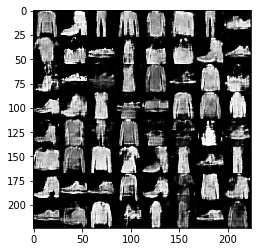

In [16]:
import cv2
import matplotlib.pyplot as plt

im = cv2.imread('/content/results/fashion-mnist/LSGAN/LSGAN_epoch001.png')
im_resized = cv2.resize(im, (224, 224), interpolation = cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

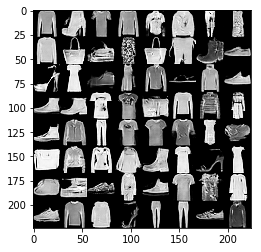

In [17]:
im = cv2.imread('/content/results/fashion-mnist/LSGAN/LSGAN_epoch050.png')
im_resized = cv2.resize(im, (224, 224), interpolation = cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(im_resized, cv2.COLOR_BGR2RGB))
plt.show()

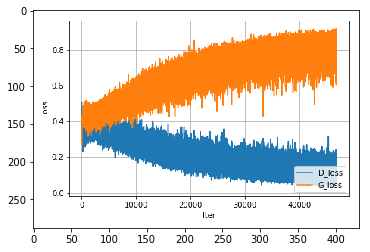

In [18]:
import matplotlib.image as mpimg

img = mpimg.imread('/content/models/fashion-mnist/LSGAN/LSGAN_loss.png')
imgplot = plt.imshow(img)
plt.show()